## Import dependencies

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import warnings; warnings.simplefilter('ignore')

## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/job-recommendation-system/'

In [ ]:
apps = pd.read_csv(folder+'data/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv(folder+'data/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv(folder+'data/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
users = pd.read_csv(folder+'data/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv(folder+'data/test_users.tsv', delimiter='\t',encoding='utf-8')

In [ ]:
apps.head()

In [ ]:
apps.columns

In [ ]:
apps.shape

In [ ]:
apps.info()

In [ ]:
user_history.head()

In [ ]:
user_history.columns

In [ ]:
user_history.shape

In [ ]:
user_history.info()

In [ ]:
jobs.head()

In [ ]:
jobs.columns

In [ ]:
jobs.shape

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091913 non-null  object
 4   Requirements  1050521 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


In [ ]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [ ]:
users.shape

(389708, 15)

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                389708 non-null  int64  
 1   WindowID              389708 non-null  int64  
 2   Split                 389708 non-null  object 
 3   City                  389708 non-null  object 
 4   State                 389218 non-null  object 
 5   Country               389708 non-null  object 
 6   ZipCode               387974 non-null  object 
 7   DegreeType            389708 non-null  object 
 8   Major                 292468 non-null  object 
 9   GraduationDate        269477 non-null  object 
 10  WorkHistoryCount      389708 non-null  int64  
 11  TotalYearsExperience  375528 non-null  float64
 12  CurrentlyEmployed     347632 non-null  object 
 13  ManagedOthers         389708 non-null  object 
 14  ManagedHowMany        389708 non-null  int64  
dtype

In [ ]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [ ]:
test_users.columns

Index(['UserID', 'WindowID'], dtype='object')

In [ ]:
test_users.shape

(22838, 2)

In [ ]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   UserID    22838 non-null  int64
 1   WindowID  22838 non-null  int64
dtypes: int64(2)
memory usage: 357.0 KB


## Exploratory Data Analysis (EDA) and Pre-processing

### Split training and testing data based on column `split`

* Here, there are three datafiles/dataframes are having attribute split. 
    * apps
    * user_history
    * users
* This data attribute indicates that whether the data record can be used for training or testing so we need to filter out based on that. 
* We are generating training and testing dataframes 


In [ ]:
apps_training = apps.loc[apps['Split'] == 'Train']

In [ ]:
apps_training.shape

(1417514, 5)

In [ ]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [ ]:
apps_testing = apps.loc[apps['Split'] == 'Test']

In [ ]:
apps_testing.shape

(185597, 5)

In [ ]:
apps_testing.head()

,UserID,WindowID,Split,ApplicationDate,JobID
126,767,1,Test,2012-04-01 14:37:20.023,85377
127,769,1,Test,2012-04-16 22:36:52.48,853328
128,769,1,Test,2012-04-09 18:59:28.193,86106
129,769,1,Test,2012-04-09 18:59:31.127,327571
130,769,1,Test,2012-04-08 21:29:11.993,119161


In [ ]:
user_history_training = user_history.loc[user_history['Split'] =='Train']

In [ ]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']
users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [ ]:
user_history_training.shape

(1652513, 5)

In [ ]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [ ]:
user_history_testing = user_history.loc[user_history['Split'] =='Test']

In [ ]:
user_history_testing.shape

(101388, 5)

In [ ]:
user_history_testing.head()

,UserID,WindowID,Split,Sequence,JobTitle
144,767,1,Test,1,Claims Adjuster
145,767,1,Test,2,Professional Baseball Player
146,767,1,Test,3,Professional Baseball Player
147,767,1,Test,4,Professional Baseball Player
148,767,1,Test,5,Professional Baseball Player


In [ ]:
users_training = users.loc[users['Split']=='Train']

In [ ]:
users_training.shape

(366870, 15)

In [ ]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
users_testing = users.loc[users['Split']=='Test']

In [ ]:
users_testing.shape

(22838, 15)

In [ ]:
users_testing.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
31,767,1,Test,Murrieta,CA,US,92562,Bachelor's,University Studies/Business,2008-05-01 00:00:00,5,16.0,No,No,0
32,769,1,Test,Roselle,IL,US,60172,Bachelor's,Radio-Television,2011-05-01 00:00:00,5,5.0,Yes,No,0
33,861,1,Test,Morris,IL,US,60450,High School,General Studies,1989-05-01 00:00:00,7,21.0,NaN,No,0
38,1006,1,Test,West Chester,PA,US,19382,High School,Not Applicable,2008-06-01 00:00:00,3,6.0,Yes,No,0
44,1192,1,Test,Cincinnati,OH,US,45255,Bachelor's,Marketing,NaN,5,6.0,Yes,No,0


### List down all training data records 

In [ ]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [ ]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [ ]:
users_training.head(5).transpose()

,0,1,2,3,4
UserID,47,72,80,98,123
WindowID,1,1,1,1,1
Split,Train,Train,Train,Train,Train
City,Paramount,La Mesa,Williamstown,Astoria,Baton Rouge
State,CA,CA,NJ,NY,LA
Country,US,US,US,US,US
ZipCode,90723,91941,08094,11105,70808
DegreeType,High School,Master's,High School,Master's,Bachelor's
Major,NaN,Anthropology,Not Applicable,Journalism,Agricultural Business
GraduationDate,1999-06-01 00:00:00,2011-01-01 00:00:00,1985-06-01 00:00:00,2007-05-01 00:00:00,2011-05-01 00:00:00


In [ ]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


### EDA for job openings based on their location information

In [ ]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


* Here note that for data attribute state, there are some blank/empty values are present. 
* We will take care of it very soon

In [ ]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [ ]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False)

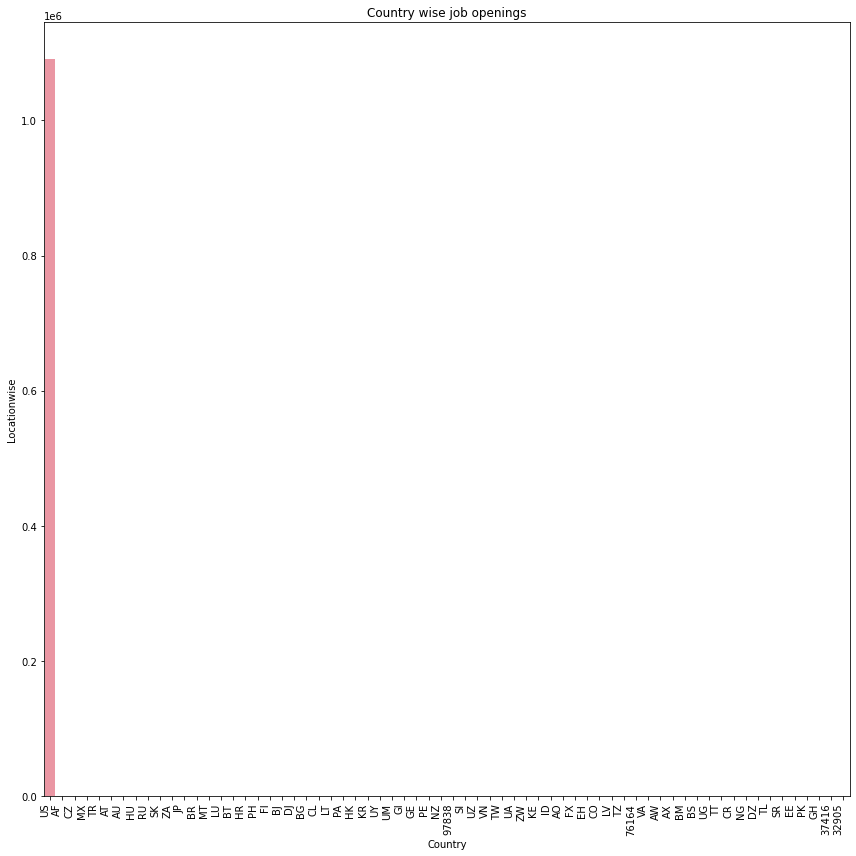

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

### pre-processing

* Now we will perform following pre-processing steps:
  * We will consider only US region for building this recommendation engine
  * We will be removing data records where state is blank or state data attribute is having numerical value.(If needed)

In [ ]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [ ]:
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


In [ ]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


In [ ]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

In [ ]:
State_wise_job_US

,State,Locationwise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998
42,PA,48999
39,OH,45048
34,NJ,35175
30,NC,34553
11,GA,33453


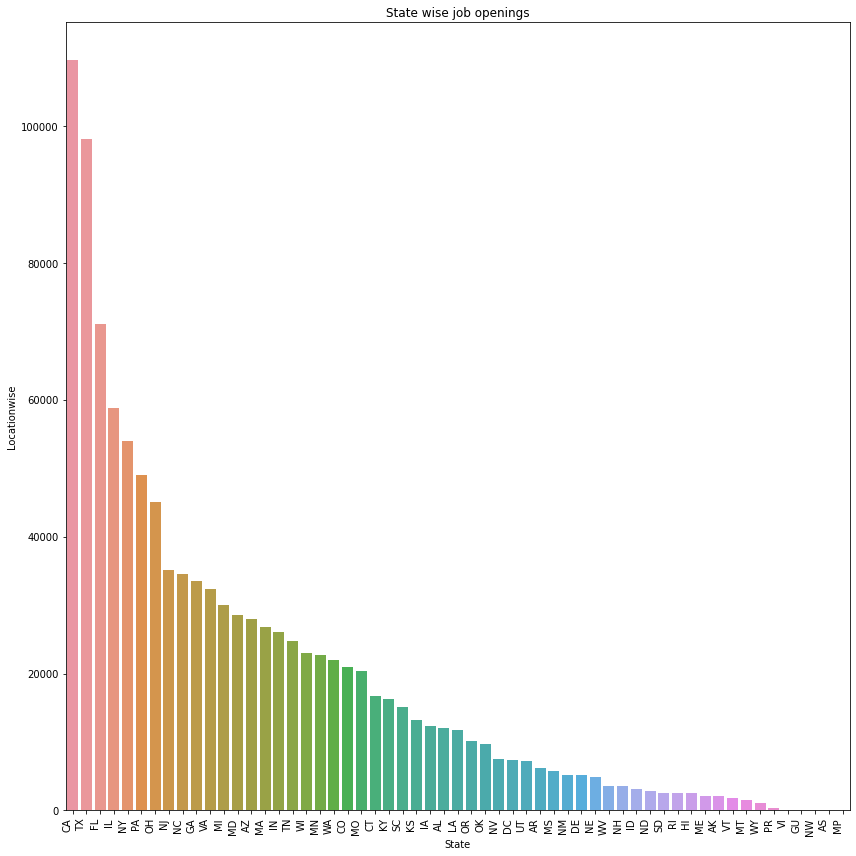

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

In [ ]:
jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
2293,Cuchillo,1
7652,Picabo,1
2290,Crystola,1
2286,Crystal Hill,1


In [ ]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)

In [ ]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]

In [ ]:
City_wise_location_th

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
6838,Newport Coast,12
4655,Ijamsville,12
2510,Denmark,12
9904,University Heights,12


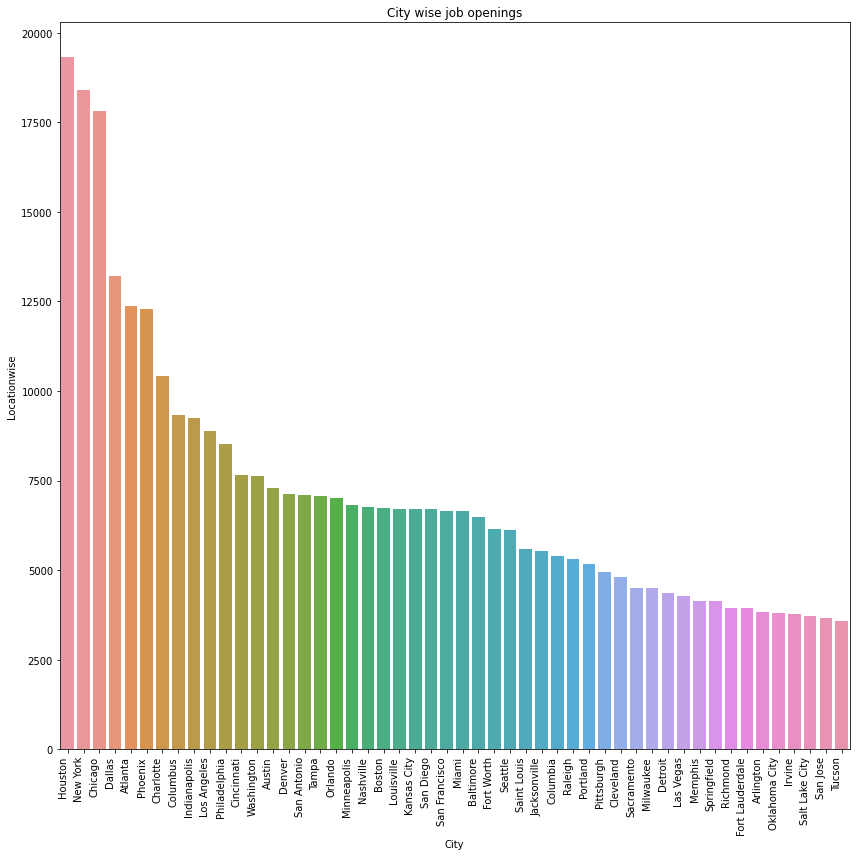

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

#### Insights:

* When we do analysis state-wise then CA, TX, FL, IL and NY are having more job opening then other state
* When we do analysis city-wise then Houston, New York, Chicago, Dallas, Atlanta and Phoenix are having more jobs     compare to other cities

We have analyze the demand (job openings). Now there is time to analyze the supply(user-profiles)

### EDA for User profiles based on their location information

In [ ]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


In [ ]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [ ]:
user_training_US.shape

(365740, 15)

In [ ]:
user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299
41,PA,16206
12,GA,15003
34,NJ,14887
38,OH,14750
30,NC,13887


In [ ]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [ ]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

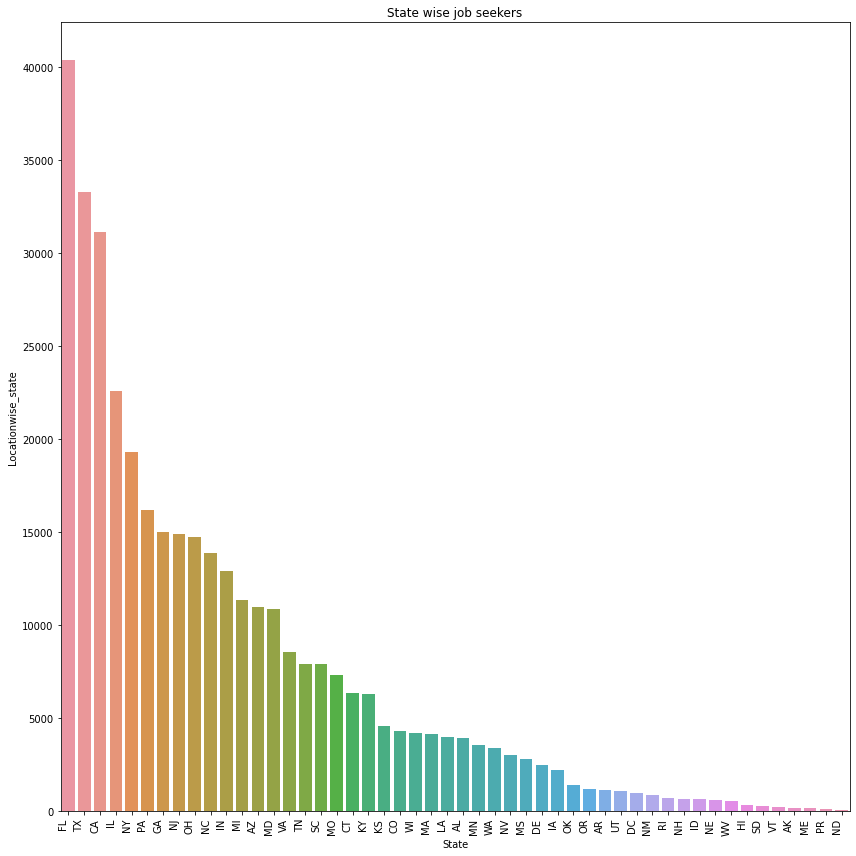

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [ ]:
user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347
...,...,...
3046,Fort Pierre,1
3042,Fort Ogden,1
7369,Rancho Murieta,1
3032,Fort McCoy,1


In [ ]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [ ]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

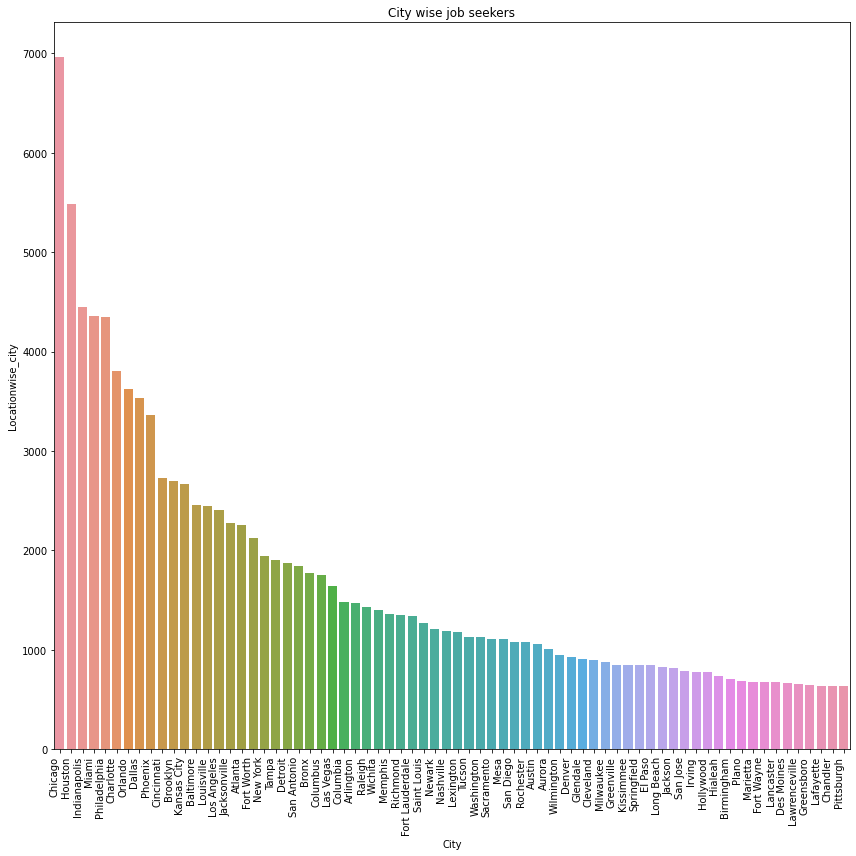

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(70))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job seekers')
plt.tight_layout()
plt.show()

* Here note that we are going to consider the US region for our further analysis. We are not removing any 
  data records right now.

* Up-till now we have obtain the popular state and city for job seeker and job creator

## revised approach


###  Let's find out Similar jobs

In [ ]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [ ]:
jobs_US.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [ ]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]
# jobs_US_base_line = jobs_US.iloc[:-1,0:8]

In [ ]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [ ]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
#jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')

jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

### TF_IDF training

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [ ]:
tfidf_matrix.shape

(10000, 515343)

In [ ]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
       0.03807697])

In [ ]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])
#indices.head(2)


In [ ]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [ ]:
get_recommendations('P/T HUMAN RESOURCES ASSISTANT').head(10)

2                 P/T HUMAN RESOURCES ASSISTANT
6313    Human Resources Admin Support Assistant
39                Front Desk for Medical Office
7465                  Human Resources Assistant
7325                   Human Resource Associate
4421                  Human Resources Assistant
2966              Human Resources Administrator
24                 CREDIT/COLLECTIONS ASSISTANT
31                                      DRIVERS
48                       TRACTOR TRAILER DRIVER
Name: Title, dtype: object

In [ ]:
get_recommendations('Security Engineer/Technical Lead').head(10)

0              Security Engineer/Technical Lead
5906                   Senior Security Engineer
3771                     Director of Admissions
6293    3 Network Architects needed - immediate
3557                          Assistant Manager
401          National Sales & Marketing Manager
2606               Inventory Analyst/ Scheduler
3757                        CLINICAL PHARMACIST
3478           Customer Service Representatives
3558                              Store Manager
Name: Title, dtype: object

In [ ]:
get_recommendations('Immediate Opening').head(10)

13                           Immediate Opening
216                      Accounting/Bookkeeper
2872    Cable TV/Internet/Telephone Installers
8423                                    no job
4028                              Electricians
4029                              Electricians
4030                              Electricians
620                                     DENTAL
93                 A/C HEATING REFRIG MECHANIC
125                                   Optician
Name: Title, dtype: object

In [ ]:
get_recommendations('EXPERIENCED ROOFERS').head(10)

26                                    EXPERIENCED ROOFERS
7949    Commercial Roofers  EXPERIENCED in  Hot Asphal...
51                                                 Driver
8012                                       OFFICE MANAGER
53                                                DRIVERS
33                         CNA OPENINGS AT TUSKAWILLA SNF
44                                   SALES REPRESENTATIVE
30                               Automotive Retail Dealer
60                                     Associate Attorney
59                                        SECURITY GUARDS
Name: Title, dtype: object

## Best approach

#### Find out similar users -- Find out for which jobs they have applied -- suggest those job to the other users who shared similar user profile.

We are finding put similar user profile based on their degree type, majors and total years of experience. 
* We will get to 10 similar users.
* We will find our which are the jobs for which these users have applied
* We take an union of these jobs and recommend the jobs all these user base

In [ ]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [ ]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [ ]:
user_based_approach.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']


In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [ ]:
tfidf_matrix.shape

(10000, 7215)

In [ ]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.17876394, 0.39845967, ..., 0.08851082, 0.27428073,
       0.19371807])

In [ ]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])
#indices.head(2)

In [ ]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [ ]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [ ]:
print(user_based_approach['UserID'].to_string(index=False))

    47
    72
    80
    98
   123
   131
   162
   178
   203
   344
   395
   411
   415
   437
   483
   496
   501
   524
   534
   547
   553
   554
   555
   589
   640
   644
   645
   655
   682
   744
   755
   886
   908
   951
   966
  1031
  1045
  1113
  1123
  1138
  1201
  1204
  1206
  1226
  1244
  1355
  1363
  1374
  1486
  1487
  1526
  1541
  1563
  1610
  1645
  1657
  1697
  1721
  1769
  1770
  1793
  1800
  1834
  1846
  1960
  2010
  2017
  2032
  2116
  2134
  2166
  2203
  2204
  2265
  2304
  2327
  2337
  2370
  2385
  2386
  2393
  2432
  2469
  2472
  2473
  2481
  2528
  2549
  2571
  2604
  2638
  2658
  2700
  2718
  2731
  2754
  2821
  2865
  2888
  2898
  2914
  2958
  2964
  2982
  3050
  3054
  3069
  3093
  3123
  3145
  3164
  3165
  3176
  3185
  3186
  3232
  3268
  3276
  3316
  3351
  3381
  3411
  3475
  3491
  3539
  3582
  3594
  3638
  3644
  3688
  3752
  3758
  3772
  3777
  3801
  3830
  3842
  3846
  3892
  3908
  3992
  4001
  4019

### Recommendation by tf-idf

In [ ]:
get_job_id(get_recommendations_userwise(206656)).head(10)

,JobID,Title,Description,City,State
76374,300028,Executive Office Assistant,Executive Office Assistant - In search of an a...,Houston,TX
130389,511505,Executive Administrative Assistant- Sugarland,<SPAN>National healthcare company is looking f...,Houston,TX
167469,654220,Legal Admin Assistant - Westchase Area,<div>\r<div>\r<p>STAFFING NOW has partnered wi...,Houston,TX
206398,807575,Executive Assistant,Executive assistant needed for an established ...,Clutch City,TX
